In [61]:
import numpy as np
def custo(x,y):
    vx = 10
    vz = 2.5
    return np.max([np.linalg.norm(x[0:2] - y[0:2])/vx, np.linalg.norm(x[2] - y[2])/vz])

In [ ]:
from shapely.geometry import Polygon  
from shapely import affinity    
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from utils import SensorCamera,Tree
from utils import lawmowerPath
import random

random.seed(42)  # For reproducibility

#DJImini3Camera = SensorCamera(9.6,9.6,4032,4032)
DJImini3Camera = SensorCamera()
desirableGSD = 1*0.43 #cm/px
altitude = DJImini3Camera.h_desirable(desirableGSD)/100
width,height = DJImini3Camera.l(altitude) # dimensão horizontal do sensor para a altitude desejada
L = 16
poly = Polygon([(-L*height, -L*width), (L*height, -L*width), (L*height, L*width), (-L*height, L*width)])
angle_deg = 0  # ângulo da varredura em graus (0 = horizontal, 90 = vertical)
waypointsLawMower = lawmowerPath(poly, height, width, angle_deg)

areas_de_interesse = []
base = Polygon([(-0.1*height*L, -0.1*width*L), (0.1*height*L,-0.1*width*L), (0.1*height*L,0.1*width*L), (-0.1*height*L,0.1*width*L)])

p = 100 # proporção de área de interesse em relação à área total
c = 1 # número de patches de interesse
base = affinity.scale(base,np.sqrt(p/c), np.sqrt(p/c), origin=(0, 0))
cont = 0
while len(areas_de_interesse) < c:
    cont += 1
    if cont > 10000:
        cont = 0
        areas_de_interesse = []
    i = random.uniform(-1 + np.sqrt(p/c)*0.1, 1 - np.sqrt(p/c)*0.1)
    j = random.uniform(-1 + np.sqrt(p/c)*0.1, 1 - np.sqrt(p/c)*0.1)     
    poly_rand = affinity.translate(base, i*L*height, j*L*width)
    if(not any(p.intersects(poly_rand) for p in areas_de_interesse)):
        areas_de_interesse.append(poly_rand)
              
interesting_area = 0
for area in areas_de_interesse:
    interesting_area += poly.intersection(base).area
interesting_area = interesting_area /poly.area
print("p =", np.round(interesting_area * 100,2), "%", "interesting")
print("C =", len(areas_de_interesse), "patches")


p = 10.0 % interesting
C = 1 patches


In [63]:
from utils import Shortcut, DeepFirst, BreadthFirst

altitude2 = DJImini3Camera.h_desirable(4*desirableGSD)/100
width2,height2 = DJImini3Camera.l(altitude2) # dimensão horizontal do sensor para a altitude desejada
waypointsInitial = lawmowerPath(poly, height2, width2, angle_deg)

LawnmowerTree = Tree(sensorCamera=DJImini3Camera)
BFTree = BreadthFirst(DJImini3Camera,areas_de_interesse)
ShortTree = Shortcut(DJImini3Camera,areas_de_interesse)
DFTree = DeepFirst(DJImini3Camera,areas_de_interesse)
DFTreeHilbert = DeepFirst(DJImini3Camera,areas_de_interesse)
LawnmowerTree.add_fistLevel_nodes(waypointsLawMower, altitude,width,height)
BFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
DFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
ShortTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)

In [64]:
from matplotlib.colors import LinearSegmentedColormap
cmap_custom = LinearSegmentedColormap.from_list(
    "azul_verde_vermelho",
    [(0.0, "blue"), (0.5, "green"), (1.0, "red")]
)

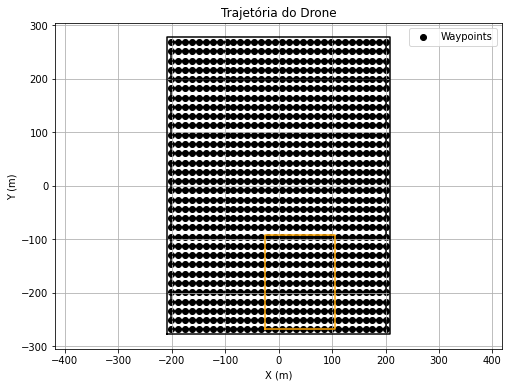

Coverage Path length (LawMower):  13.43663999999975  km
Coverage Path cost (LawMower):  1343.664000000033  s


In [65]:
waypoints = np.array(waypointsLawMower)
fig, ax = plt.subplots(figsize=(8, 6))
waypoints_x = [wp[0] for wp in waypoints]
waypoints_y = [wp[1] for wp in waypoints]
ax.scatter(waypoints_x, waypoints_y, color='black', label='Waypoints', marker='o')
ax.plot(waypoints_x, waypoints_y, color='black')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black')
for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.plot(x, y, color='Orange')
plt.title('Trajetória do Drone')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
path_length5 = 0
path_cost5 = 0
for i in range(np.size(waypoints,0)-1):
    path_length5 += np.linalg.norm(waypoints[i+1] - waypoints[i])
    path_cost5 += np.linalg.norm(waypoints[i+1] - waypoints[i])/10
print("Coverage Path length (LawMower): ", path_length5/1000, " km")
print("Coverage Path cost (LawMower): ", path_cost5, " s")

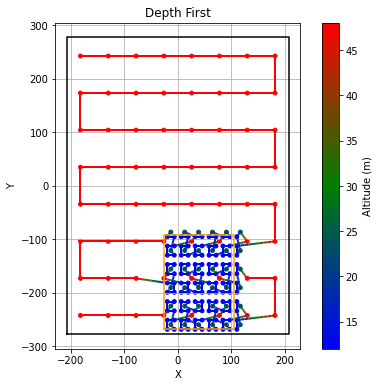

Coverage Path length (Depth First):  6.300272930523705  km


In [66]:
waypointsDF = np.array(DFTree.generate_path())

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsDF) - 1):
    segment = interp_segment(waypointsDF[i], waypointsDF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsDF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsDF[:, 0], waypointsDF[:, 1], c=waypointsDF[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Depth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length4 = 0
path_cost4 = 0
for i in range(np.size(waypointsDF,0)-1):
    path_length4 += np.linalg.norm(waypointsDF[i+1] - waypointsDF[i])
    path_cost4 += custo(waypointsDF[i], waypointsDF[i+1])
print("Coverage Path length (Depth First): ", path_length4/1000, " km")

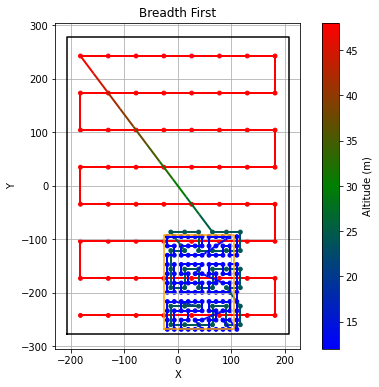

Coverage Path length (Breadth First):  6.888763755768971  km


In [67]:
waypointsBF = np.array(BFTree.generate_path())
# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsBF) - 1):
    segment = interp_segment(waypointsBF[i], waypointsBF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsBF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsBF[:, 0], waypointsBF[:, 1], c=waypointsBF[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Breadth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length3 = 0
path_cost3 = 0
for i in range(np.size(waypointsBF,0)-1):
    path_length3 += np.linalg.norm(waypointsBF[i+1] - waypointsBF[i])
    path_cost3 += custo(waypointsBF[i], waypointsBF[i+1])
print("Coverage Path length (Breadth First): ", path_length3/1000, " km")

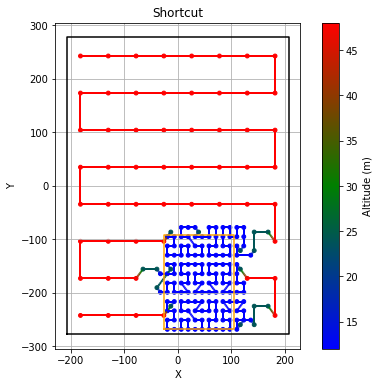

Coverage Path length (Shortcut):  5.435471671020292  km


In [68]:
waypointsSC = np.array(ShortTree.generate_path())
# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsSC) - 1):
    segment = interp_segment(waypointsSC[i], waypointsSC[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsSC[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsSC[:, 0], waypointsSC[:, 1], c=waypointsSC[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Shortcut")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
path_cost = 0
for i in range(0,np.size(waypointsSC,0)-1):
    path_length += np.linalg.norm(waypointsSC[i+1] - waypointsSC[i])
    path_cost += custo(waypointsSC[i], waypointsSC[i+1])
print("Coverage Path length (Shortcut): ", path_length/1000, " km")

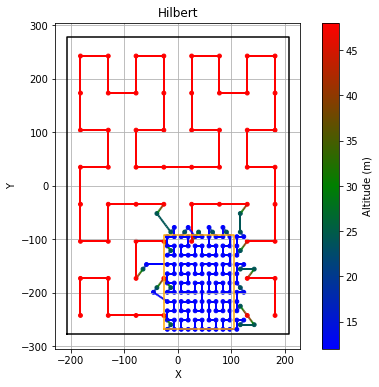

Coverage Path length Hilbert:  5.874920723084908  km


In [69]:
from utils import HilbertTree
DFTreeHilbert = HilbertTree(DJImini3Camera,areas_de_interesse)
DFTreeHilbert.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
DFTreeHilbert.add_another_levels()

waypoints = np.array(DFTreeHilbert.generate_path())

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypoints) - 1):
    segment = interp_segment(waypoints[i], waypoints[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypoints[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypoints[:, 0], waypoints[:, 1], c=waypoints[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Hilbert")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length2 = 0
path_cost2 = 0
for i in range(0,np.size(waypoints,0)-1):
    path_length2 += np.linalg.norm(waypoints[i+1] - waypoints[i])
    path_cost2 += custo(waypoints[i], waypoints[i+1])
print("Coverage Path length Hilbert: ", path_length2/1000, " km")

In [70]:
print("Coverage Path length (Shortcut Hilbert): ", path_length2/path_length5)
print("Coverage Path length (Shortcut): ", path_length/path_length5)
print("Coverage Path length (Depth First): ", path_length4/path_length5)
print("Coverage Path length (Breadth First): ", path_length3/path_length5)
print("Coverage Path length (LawMower): ", path_length5/path_length5)

Coverage Path length (Shortcut Hilbert):  0.4372313854568566
Coverage Path length (Shortcut):  0.40452610704911296
Coverage Path length (Depth First):  0.46888752921294474
Coverage Path length (Breadth First):  0.5126849983157321
Coverage Path length (LawMower):  1.0


In [71]:
print("Coverage Path cost (Shortcut Hilbert): ", path_cost2/path_cost5)
print("Coverage Path cost (Shortcut): ", path_cost/path_cost5)
print("Coverage Path cost (Depth First): ", path_cost3/path_cost5)
print("Coverage Path cost (Breadth First): ", path_cost3/path_cost5)
print("Coverage Path cost (LawMower): ", path_cost5/path_cost5)

Coverage Path cost (Shortcut Hilbert):  0.5415734739411451
Coverage Path cost (Shortcut):  0.46618279569891324
Coverage Path cost (Depth First):  0.5126462109802389
Coverage Path cost (Breadth First):  0.5126462109802389
Coverage Path cost (LawMower):  1.0


In [72]:
print(np.linalg.norm(waypoints[2] - waypoints[3]))
print(height)
print(np.linalg.norm(waypoints[3] - waypoints[4]))
print(width)


69.35039999999998
13.003199999999998
52.012799999999984
17.337599999999995
